In [77]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
from pathlib import Path
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn import metrics
from contextlib import contextmanager

pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [2]:
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

## Data preparation

In [3]:
raw_data = pd.read_csv('datafull.csv', dtype = str)
raw_data.shape

(74576, 71)

In [4]:
#Removing any null products.
df = raw_data.drop_duplicates(subset=['itemid'], keep='first')
df = df.dropna(subset=['itemid'])
df = df.reset_index()
df.shape

(68952, 72)

In [5]:
#Checking any further null values.
df[df.columns[df.isnull().any()]].isnull().sum()

description               59
reference_item_id      68952
shop_location             14
shop_vouchers          50374
wholesale_tier_list    68345
tier_variations          153
attributes             48792
dtype: int64

In [6]:
#Dropping these as they have excessive null values.
df = df.drop(columns=['exclusive_price_info', 'reference_item_id'])

#Fillnas to allow further manipulations.
df['discount'] = df['discount'].fillna('0') #str to maintain same dtype.
df = df.fillna('None')

In [7]:
#Splitting string into lists, delimiter was set as ';'.
df['categories'] = df['categories'].apply(lambda x : x.split(';'))
df['fe_categories'] = df['fe_categories'].apply(lambda x : x.split(';'))
df['shop_vouchers'] = df['shop_vouchers'].apply(lambda x : x.split(';'))
df['wholesale_tier_list'] = df['wholesale_tier_list'].apply(lambda x : x.split(';'))
df['models'] = df['models'].apply(lambda x : x.split(';'))
df['tier_variations'] = df['tier_variations'].apply(lambda x : x.split(';'))
df['attributes'] = df['attributes'].apply(lambda x : x.split(';'))
df['rating_count'] = df['rating_count'].apply(lambda x : x.split(';'))

#Making separate df for models and attributes to reference later on.
models = pd.DataFrame(df.models.values.tolist()).add_prefix('model')
models.insert(0, 'itemid', df.itemid)

# raw_attributes = pd.DataFrame(df.attributes.values.tolist()).add_prefix('attribute')
# raw_attributes.insert(0, 'itemid', df.itemid)

# attributes = pd.read_csv('tableau_attributes.csv')

#Spltting categories into multiple columns.
df = pd.concat([df, pd.DataFrame(df.categories.values.tolist()).add_prefix('category')], axis=1)
df = pd.concat([df, pd.DataFrame(df.fe_categories.values.tolist()).add_prefix('fe_category')], axis=1)


In [8]:
# Commented as it took 10 minutes to run. This was exported into a csv to be used again in above cell.
# Kept in here just to show how it was made.

# attributes= pd.DataFrame({
#     'itemid': [],
#     'name': [],
#     'warranty_type': [],
#     'warranty_duration': [],
#     'recommended_age': [],
#     'sports_type': [],
#     'age_group': [],
#     'gender': [],
#     'apparel_function': [],
#     'material': [],
#     'bicycle_type': [],
#     'bicycle_parts_type': [],
#     'country_origin': [],
#     'wheel_diameter': [],
#     'weight': [],
#     'number_of_speeds': []
# })

# for index, row in raw_attributes.iterrows():
#     attributes.at[index, 'itemid'] = row['itemid']
#     for i in range(18):
#         attribute_value = row[f'attribute{i}']
#         if attribute_value != 'None':
#             if 'Warranty Type' in attribute_value:
#                 attributes.at[index, 'warranty_type'] = attribute_value.removeprefix('Warranty Type - ')
#             elif 'Warranty Duration' in attribute_value:
#                 attributes.at[index, 'warranty_duration'] = attribute_value.removeprefix('Warranty Duration - ')
#             elif 'Recommended Age' in attribute_value:
#                 attributes.at[index, 'recommended_age'] = attribute_value.removeprefix('Recommended Age - ')
#             elif 'Sports Type' in attribute_value:
#                 attributes.at[index, 'sports_type'] = attribute_value.removeprefix('Sports Type - ')
#             elif 'Age Group' in attribute_value:
#                 attributes.at[index, 'age_group'] = attribute_value.removeprefix('Age Group - ')
#             elif 'Gender' in attribute_value:
#                 attributes.at[index, 'gender'] = attribute_value.removeprefix('Gender - ')
#             elif 'Apparel Function' in attribute_value:
#                 attributes.at[index, 'apparel_function'] = attribute_value.removeprefix('Apparel Function - ')
#             elif 'Material' in attribute_value:
#                 attributes.at[index, 'material'] = attribute_value.removeprefix('Material - ')
#             elif 'Bicycle Type' in attribute_value:
#                 attributes.at[index, 'bicycle_type'] = attribute_value.removeprefix('Bicycle Type - ')
#             elif 'Bicycle Parts Type' in attribute_value:
#                 attributes.at[index, 'bicycle_parts_type'] = attribute_value.removeprefix('Bicycle Parts Type - ')
#             elif 'Country of Origin' in attribute_value:
#                 attributes.at[index, 'country_origin'] = attribute_value.removeprefix('Country of Origin - ')
#             elif 'Wheel Diameter' in attribute_value:
#                 attributes.at[index, 'wheel_diameter'] = attribute_value.removeprefix('Wheel Diameter - ')
#             elif 'Weight' in attribute_value:
#                 attributes.at[index, 'weight'] = attribute_value.removeprefix('Weight - ')
#             elif 'Number of Speeds' in attribute_value:
#                 attributes.at[index, 'number_of_speeds'] = attribute_value.removeprefix('Number of Speeds - ')

# attributes = attributes.drop(columns=['name'])
# attributes.insert(1, 'name', df.name)
# attributes.to_csv('tableau_attributes.csv')

In [9]:
#categorizing columns
int_cols = ['index', 'itemid', 'shopid', 'userid',
            'price_max_before_discount', 'price_before_discount', 'price_min_before_discount',
            'price_max', 'price', 'price_min',
            'historical_sold', 'sold',
            'ctime',
            'catid',
            'liked_count', 'cmt_count',
            'bundle_deal_id',
            'estimated_days',
            'raw_discount',
            'other_stock', 'discount_stock', 'normal_stock',
            'current_promotion_reserved_stock',
            'brand_id'] #ints
flt_cols = ['rating_star'] #floats
bool_cols = ['has_lowest_price_guarantee', 'show_shopee_verified_label',
             'shopee_verified', 'is_preferred_plus_seller',
             'can_use_bundle_deal', 'can_use_wholesale', 'cb_option',
             'is_pre_order', 'show_free_shipping', 'cod_flag',
             'show_original_guarantee', 'item_has_post',
             'current_promotion_has_reserve_stock',
             'is_cc_installment_payment_eligible'] #bools
objects_cols = ['name', 'description', 'brand', 'categories', 'fe_categories',
                'shop_vouchers', 'wholesale_tier_list', 'models', 'tier_variations',
                'attributes',
                'category0','category1','category2','category3','category4',
                'fe_category0','fe_category1','fe_category2', 'rating_count'] #keep as is
category_cols = ['item_status', 'status', 'condition', 'shop_location']
remove_cols = ['is_mart', 'liked', 'is_adult', 'item_type',
                'is_official_shop', 'is_service_by_shopee',
                'show_recycling_info', 'show_best_price_guarantee',
                'item_has_video', 'item_has_size_recommendation',
                'is_non_cc_installment_payment_eligible',
                'has_low_fulfillment_rate',
                'is_partial_fulfilled',
                'userid', 'discount', 'show_discount', 'stock'] #non_target cols

In [10]:
#Converting cols to appropriate dtypes
df[int_cols] = df[int_cols].astype(int)
df[flt_cols] = df[flt_cols].astype(float)
df[category_cols] = df[category_cols].astype('category')
for col in bool_cols:
    df[col] = df[col].map({'0': False, '1': True, 'False': False, 'True': True})

#Convert ctime to datetime    
df['ctime'] = pd.to_datetime(df['ctime'], unit='s')

#Remove cols
df = df.drop(columns=remove_cols)

df.shape

(68952, 61)

In [11]:
#Set the -1 values to base value for the prices before discount
df['price_max_before_discount'] = df.apply(lambda row : row['price_max'] if (row['raw_discount'] == 0) else row['price_max_before_discount'], axis = 1)
df['price_before_discount'] = df.apply(lambda row : row['price'] if (row['raw_discount'] == 0) else row['price_before_discount'], axis = 1)
df['price_min_before_discount'] = df.apply(lambda row : row['price_min'] if (row['raw_discount'] == 0) else row['price_min_before_discount'], axis = 1)

In [12]:
#Converting price into real life amounts
price_cols = ['price_max_before_discount', 'price_before_discount', 'price_min_before_discount',
              'price_max', 'price', 'price_min']

df[price_cols] = df[price_cols].apply(lambda x : x/100000)

In [13]:
#Filling null values from split columns and setting index to finalize
df[['category2','category3','category4','fe_category2']] = df[['category2','category3','category4','fe_category2']].fillna('None')
df = df.set_index('index')
df.head(3)

,itemid,shopid,price_max_before_discount,has_lowest_price_guarantee,price_before_discount,price_min_before_discount,price_min,price_max,price,historical_sold,sold,raw_discount,name,ctime,item_status,status,condition,catid,description,show_shopee_verified_label,brand,liked_count,cmt_count,shopee_verified,is_preferred_plus_seller,...,other_stock,item_has_post,discount_stock,current_promotion_has_reserve_stock,current_promotion_reserved_stock,normal_stock,brand_id,is_cc_installment_payment_eligible,categories,fe_categories,shop_vouchers,wholesale_tier_list,models,tier_variations,attributes,rating_star,rating_count,category0,category1,category2,category3,category4,fe_category0,fe_category1,fe_category2
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,8183479417,133042939,55.0,False,55.0,55.0,55.0,55.0,55.0,31,15,0,[MONTON] CYCLING MESH BASE LAYER FOR SUMMER,2021-07-28 06:30:58,normal,1,1,100637,"The size is Asian Size, 1 or 2 size SMALLER than other US/Europe brands, please refer to our Size Chart.\nExample: Asian Size L = US/EU size M\n\nCycling summer base layer\nA sleeveless base layer cycling constructed from a breathable and quick dry fabric at a very reasonable price. With a all-around supportive fit and a highly effective wicking performance, it is designed to aid temperature regulation and improve comfort in hot weather riding.\n\nA good summer mesh base layer cycling works hard to wick your sweat away from the skin, to regulate body temperature whilst wicking away any unwanted moisture.\n\nLightweight and breathable fabric (82% polyester, 18% elastane)",False,Monton Sports,15,13,False,False,...,13,False,0,False,0,13,1008772,False,"[Sports & Outdoors, Sports & Outdoor Apparels, Jerseys]","[Men Clothes, Sports Wear, Jerseys]",[KHASJUNEB - 1.0 off min spend 0.0],[None],"[White,L - price : 55.0 from 0.0, stock : 2, White,XL - price : 55.0 from 0.0, stock : 2, White,XXL - price : 55.0 from 0.0, stock : 1, White,S - price : 55.0 from 0.0, stock : 0, White,XXXL - price : 55.0 from 0.0, stock : 0, Black,L - price : 55.0 from 0.0, stock : 1, White,M - price : 55.0 from 0.0, stock : 1, Black,XXL - price : 55.0 from 0.0, stock : 1, Black,S - price : 55.0 from 0.0, stock : 1, Black,XXXL - price : 55.0 from 0.0, stock : 0, Black,M - price : 55.0 from 0.0, stock : 2, Black,XL - price : 55.0 from 0.0, stock : 2]","[Color - Black,White, Size - S,M,L,XL,XXL,XXXL]","[Gender - Unisex, Apparel Function - Dry Fit, Material - Polyester, Elastane, Sleeve Length - Sleeveless, Sports Type - Cycling]",4.846154,"[13, 0, 0, 1, 0, 12]",Sports & Outdoors,Sports & Outdoor Apparels,Jerseys,None,None,Men Clothes,Sports Wear,Jerseys
1,8043008136,133042939,20.0,False,20.0,20.0,20.0,20.0,20.0,41,4,0,[MONTON] SKULL KNIT DAILY II 2022 CYCLING SOCKS,2021-04-16 04:23:05,normal,1,1,100637,"Comfortable, supportive socks feels comfortable against the skin for cooler rides.\n\nMade from high-grade organic long staple cotton, the material feels comfortable against the skin. Warm, breathable, soft and foot shaped in the right places for cycling. With a ribbed elasticated cuff that sits high on the ankle, the fabric is stretchy throughout. Elasticated section around the mid-foot to fit securely.\n\nThese cotton socks are intended for temperatures from 18 to 32°C.\n\nFeatures\nWell-shaped and grip securely\nRibbed tube and mesh ventilation\nHigh level of support and comfort\n\nCotton: 42.6%\nPolyamide: 53.9%\nSpandex: 3.5%\n\n18°-32°C / 64°-90°F\n\nRecycled package: with license of Der Grüne Punkt and LD-PE 04",False,Monton Sports,32,14,False,False,...,37,False,0,False,0,37,1008772,False,"[Sports & Outdoors, Sports & Outdoor Recreation Equipments, Cycling, Bicycle Parts & Accessories]","[Sports & Outdoor, Cycling & Skates, Parts & Components]",[KHASJUNEB - 1.0 off min spend 0.0],[None],"[Tuesday Pink,S EU 36-39 - price : 20.0 from 0.0, stock : 3, Monday Yellow,S EU 36-39 - price : 20.0 from 0.0, stock : 0, Thursday Orange,L EU 39-45 - price : 20.0 from 0.0, s

In [14]:
#Merging with shop details
shop_df = pd.read_csv('shops.csv', index_col=0)
shop_df = shop_df.drop_duplicates(subset=['shopid'], keep='first') # Has some duplicates
df = pd.merge(df,shop_df[['shopid','name']], on='shopid', how='inner')
df = df.rename(columns={'name_x': 'product_name', 'name_y': 'shop_name'})

In [15]:
#Taking a subset of columns and rearranging for easier analysis
sub_cols = ['itemid',
            'shopid',
            'product_name',
            'description',
            'brand',
            'price_min',
            'price',
            'price_max',
            'price_min_before_discount',
            'price_before_discount',
            'price_max_before_discount',
            'historical_sold',
            'sold',
            'category0',
            'category1',
            'category2',
            'category3',
            'category4',
            'fe_category0',
            'fe_category1',
            'fe_category2',
            'normal_stock',
            'discount_stock',
            'other_stock',
            'current_promotion_reserved_stock',
            'raw_discount',
            'ctime',
            'liked_count',
            'cmt_count',
            'shop_name',
            'shop_location',
            'rating_star',
            'rating_count',
            'item_status',
            'show_shopee_verified_label',
            'show_original_guarantee',
            'show_free_shipping',
            'cod_flag',
            'item_has_post',
            'shopee_verified',
            'is_preferred_plus_seller',
            'is_cc_installment_payment_eligible',
            'wholesale_tier_list',
            'cb_option',
            'is_pre_order',
            'estimated_days']

df_full = df.copy()
df = df[sub_cols]
df_copy = df.copy()
df = df.query('sold != 0') #Filter out non sales

#set revenue columns
df['revenue'] = df['price'] * df['sold']
df['historical_revenue'] = df['price'] * df['historical_sold']

#reset index
df = df.reset_index(drop=True)

In [16]:
import re

def get_clean_text(input_text) -> str:
    '''Removes emojis and \n code to reduce noise for modelling. Can be used for name or description. Also reduced model training time by half.'''
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U0001F1F2-\U0001F1F4"  # Macau flag
            u"\U0001F1E6-\U0001F1FF"  # flags
            u"\U0001F600-\U0001F64F"
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U0001F1F2"
            u"\U0001F1F4"
            u"\U0001F620"
            u"\u200d"
            u"\u2640-\u2642"
            "]+", flags=re.UNICODE)

    text = emoji_pattern.sub(r' ', input_text)
    text = text.replace('\n', ' ')
    text = re.sub(r'(?<=[.,])(?=[^\s])', r' ', text)
    text = re.sub(r' +', ' ', text)
    return text

df.description = df.description.apply(get_clean_text)

### Feature Engineering

Acceptable Categories:

fe_categories0:
- Sports & Outdoor
- Baby & Toys (kids bikes, will be further filtered in below categories)
- Health & Beauty (energy bars, filtered by only allowing 'Sports Nutrition' from fe_cat2)
- Men Clothes
- Women Clothes
- Mobile & Accessories (bike computers only bike lights, filtered in fe_cat2)
- Automotive (brakes, chain lube, filtered in fe_cat2)
- Groceries & Pets (energy bars, filtered in fe_cat2)

fe_categories1:
- Cycling & Skates
- Kids Sports & Outdoor Play
- Performance Wear
- Others
- Men's Sports Shoes (cycling shoes only, needs filtering)
- Baby gear (baby carriers, filtered in fe_cat2)
- Eyewear (needs filtering)
- Sports Wear (needs filtering)
- More Accessories (needs filtering)
- Cases & Covers (bike computer cases, phone holders, filtering)
- Socks
- Tyres, Rims & Accessories (filter out non bikes)
- Exercise & Fitness Equipment (only trainers and bar tapes, filtered out below in accessories)
- Outdoor & Adventure (filtered by only allowing 'Outdoor Bags' from fe_cat2)
- Motor Accessories (locks, phone holders, filtered 'in fe_cat2)
- Beverages (energy bars, filtered in fe_cat2)
- Cars Oils & Fluids (chain lube, filtered in fe_cat2)
- Motorcycles & Parts (brakes, filtered in fe_cat2)
- Cereals (energy bars, filtered in fe_cat2)
- Baby Clothing (baby gloves, filtered in fe_cat2)
- Cool Gadgets (bike lights, filtered in fe_cat2)
- Wearables (magene, filtered in fe_cat2)
- Car Replacement Parts (brake system, filtered in fe_cat2 and keywords)


fe_categories2:
- Parts & Components
- Bikes
- Others
- Scooters (filter out non bikes)
- Bicycles, Scooters & Ride-ons (filter out cars, trucks, non bikes)
- Safety Equipment
- Sports Nutrition
- Pants & Shorts (filtered by performance wear)
- Sunglasses (filter out non bike keywords)
- Jerseys
- Cycling Jerseys
- Lights & Lanterns (filter out non bike keywords)
- Accessories (filter out non bike, only allow trainers)
- Hats (filter out non bike)
- Eyeglasses
- Compression Tops
- Outdoor Bags
- Locks & Security
- Supports, Tapes & Braces (bar tape)
- Training Wear
- Rims & Accessories (filters out tyres above and by keyword blacklist)
- Phone Holders
- Pedometers
- Sports & Energy Drinks
- Sport Apparel
- Greases & Lubricants
- Tires & Others
- Brake System
- Breakfast Bars (energy bars)
- Jackets
- Baby Carrier
- Baby Gloves
- Sportswear
- USB Light
- GPS Trackers
- Brake Systems
- Phone Holder & Stand

keyword blacklist filter:
['motorcycle', 'motor', 'scooter', 'cars', 'truck', 'kereta', 'motorbike', 'ATV', 'tractor', 'mower']

whitelist filter:
['bicycle', 'bike', 'basikal', 'cycling', 'cycle', 'tricycle', 'mtb', 'bmx']

In [17]:
fe_cat0 = ['Sports & Outdoor', 'Baby & Toys', 'Health & Beauty', 'Men Clothes',
           'Women Clothes', 'Mobile & Accessories', 'Automotive', 'Groceries & Pets']

fe_cat1 = ['Cycling & Skates', 'Kids Sports & Outdoor Play', 'Performance Wear', 'Others',
           "Men's Sports", 'Baby Gear', 'Eyewear', 'Sports Wear', 'More Accessories',
           'Cases & Covers', 'Socks', 'Tyres, Rims & Accessories', 'Exercise & Fitness Equipment',
           'Outdoor & Adventure', 'Motor Accessories', 'Beverages', 'Cars Oils & Fluids',
           'Motorcycles & Parts', 'Cereals', 'Baby Clothing', 'Cool Gadgets', 'Wearables',
           'Car Replacement Parts']

fe_cat2 = ['Parts & Components', 'Bikes', 'Others', 'Scooters', 'Bicycles, Scooter & Ride-ons',
           'Safety Equipment', 'Sports Nutrition', 'Pants & Shorts', 'Sunglasses', 'Jerseys',
           'Cycling Jerseys', 'Lights & Lanterns', 'Accessories', 'Hats', 'Eyeglasses',
           'Compression Tops', 'Outdoor Bags', 'Locks & Security', 'Supports, Tapes & Braces',
           'Training Wear', 'Rims & Accessories', 'Phone Holders', 'Pedometers',
           'Sports & Energy Drinks', 'Sport Apparel', 'Greases & Lubricats', 'Tires & Others',
           'Brake System', 'Breakfast Bars', 'Jackets', 'Baby Carrier', 'Baby Gloves', 'Sportswear',
           'USB Light', 'GPS Trackers', 'Brake Systems', 'Phone Holder & Stand']

keyword_blacklist = ['motorcycle', 'motor', 'scooter', 'cars', 'truck', 'kereta', 'motorbike', 'ATV',
                     'tractor', 'mower', 'gym']

keyword_whitelist = ['bicycle', 'bike', 'basikal', 'cycling', 'cycle', 'tricycle', 'mtb', 'bmx']

In [18]:
df.shape

(9699, 48)

In [19]:
filtered_df = df[
    df['fe_category0'].isin(fe_cat0) & df['fe_category1'].isin(fe_cat1) & df['fe_category2'].isin(fe_cat2) |
    df['product_name'].str.contains('|'.join(keyword_whitelist), case=False)]

filtered_df = filtered_df[
    ~filtered_df['product_name'].str.contains('|'.join(keyword_blacklist), case=False) |
    filtered_df['product_name'].str.contains('|'.join(keyword_whitelist), case=False)]

In [20]:
filtered_df.shape

(8139, 48)

In [21]:
filtered_df.sample(3)

,itemid,shopid,product_name,description,brand,price_min,price,price_max,price_min_before_discount,price_before_discount,price_max_before_discount,historical_sold,sold,category0,category1,category2,category3,category4,fe_category0,fe_category1,fe_category2,normal_stock,discount_stock,other_stock,current_promotion_reserved_stock,raw_discount,ctime,liked_count,cmt_count,shop_name,shop_location,rating_star,rating_count,item_status,show_shopee_verified_label,show_original_guarantee,show_free_shipping,cod_flag,item_has_post,shopee_verified,is_preferred_plus_seller,is_cc_installment_payment_eligible,wholesale_tier_list,cb_option,is_pre_order,estimated_days,revenue,historical_revenue
6449,10050377699,184566390,🔥Ready Stock🔥iSports Hypercool Cycling Short Slevee Unisex Jersey Bicycle RB MTB Road Bikes Mountain Cyclist,"Local Malaysia Seller (Pos dari PENANG) Ready Stock!! Ship out on the same day if order before 12p. m (working day) Who wear I-Sports Asia ranking number one Pro team TSG Terengganu Cycling Team, Malaysia National Cycling Team, TSG Cycling Academy, Indonesia National Cycling Team and Brunei Darussalam National Cycling Team iSports Hypercool Cycling Unisex Short Sleeve Jersey Semi Race Cut Jersey Size inch: Size suggestion for Chest (inch) : XS-33""to35"", S-35""to37"", M-37""to39"", L-39""to41"", XL-41""to43"", XXL-43""to45"", 3XL-45""to47"", 4XL-47""to49"" Description Brand: iSports Model: Hypercool Cutting: Semi Race cut Unisex - High quality 3 material jersey - Hypercool fabric 140gsm - breathable - Jacquard Mesh Superior ventilation from light mesh panelling in the side panels. - 2. 5CM Slash epoxy elastic gripper - UV protection - Full length zipper - 3 rear pocket -2 Side pocket reflective Hypercool 140gsm fabric, is a new technology fibre cloth resulting in a very breathable and super light...",ISports,65.0,65.0,65.0,65.0,65.0,65.0,91,1,Sports & Outdoors,Sports & Outdoor Apparels,Jerseys,None,None,Sports & Outdoor,Cycling & Skates,Cycling Jerseys,44,0,44,0,0,2021-09-18 18:14:42,30,47,iSports,Penang,4.893617,"[47, 0, 0, 2, 1, 44]",normal,True,True,False,False,False,True,True,False,[None],False,False,2,65.0,5915.0
6531,21643386406,184566390,🔥Ready Stock🔥iSports Knots Bib 3/4 Pants Cycling RB MTB Road Bike Mountain bikes Padded Cycling bib knicker Dark Blue,"Local Malaysia Seller (Pos dari PENANG) Ready Stock!! iSports Knots bib 3/4 Brand:iSports® Model: Knots Bib Copyright @iSports Size suggestion for waist (Unit inch""): XS(27""-30""), S (30""-32""), M (32""-34""), L (34""-36""), XL (36""-38""), XXL (38""-41"") The Knots Bibs are defined by their aerodynamic fit. Constructed from compressive textiles with high elasticity, the Knots Bibs are fitted to match your optimal riding position without restricting mobility. Pro Level C3 chamois Padding - MADE IN BELGIUM Product details: > Aerodynamic race fit > Specifically engineered for high-intensity training and racing > Pro Level C3 chamois Padding - MADE IN BELGIUM > Integrated Italian TTP gripper elastic with exposed Texetec® to hold the leg in place > Low profile shoulder straps > Highly wicking mesh back panel > Material: 75% Polyester, 25% Elastane Who wear iSports Asia ranking number one Pro team TSG Terengganu Polygon Cycling Team & Malaysia National Cycling Team. Our Showroom Walk in Penang Sh...",ISports,265.0,265.0,265.0,265.0,265.0,265.0,15,1,Sports & Outdoors,Sports & Outdoor Apparels,Bottoms,None,None,Sports & Outdoor,Performance Wear,Pants & Shorts,40,0,40,0,0,2022-09-07 15:39:33,6,9,iSports,Penang,5.000000,"[9, 0, 0, 0, 0, 9]",normal,True,True,False,False,False,True,True,False,[None],False,False,2,265.0,3975.0
8145,10316432990,153920839,MOTOWOLF Ice Cool Motorcycle Riding Balaclava Mask Headgear Scarf bandana tube sarung kepala,"Motowolf® Ice Cool Motorcycle Riding Balaclava Motowolf® Ice Cool Motorcycle Riding Balaclava is a riding balaclava that protects you from harmful UV-rays. Made with Icy-cool Technology Fabric, it is super breathable and comfortab

In [22]:
df1 = filtered_df[['itemid','product_name', 'description', 'fe_category0', 'fe_category1', 'fe_category2']].copy()

In [23]:
train_df = df1[['description', 'fe_category0']]
train_df.columns  = ['description', 'product_category']

In [24]:
train_df.product_category.value_counts()

Sports & Outdoor          7458
Automotive                 203
Men Clothes                130
Baby & Toys                113
Fashion Accessories         98
Games, Books & Hobbies      48
Health & Beauty             39
Home & Living               18
Mobile & Accessories        11
Groceries & Pets             8
Men's Bags & Wallets         4
Women Clothes                3
Travel & Luggage             2
Cameras & Drones             2
Men Shoes                    1
Women's Bags                 1
Name: product_category, dtype: int64

In [25]:
train_df['category_id'] = train_df['product_category'].factorize()[0]

/tmp/ipykernel_20723/1909202124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['category_id'] = train_df['product_category'].factorize()[0]


In [26]:
category_id_df = train_df[['product_category', 'category_id']].drop_duplicates()
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'product_category']].values)

In [27]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                       ngram_range=(1, 2),
                       stop_words='english')

features = tfidf.fit_transform(train_df.description).toarray()
labels = train_df.category_id
print(features.shape)

(8139, 26289)


In [28]:
# Finding the three most correlated terms with each of the product categories
N = 3
for product_category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(product_category))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Automotive:
  * Most Correlated Unigrams are: honda, yamaha, motorcycle
  * Most Correlated Bigrams are: ways use, fast delivery, stock fast

==> Baby & Toys:
  * Most Correlated Unigrams are: toy, age, tricycle
  * Most Correlated Bigrams are: tricycle kids, years old, age years

==> Cameras & Drones:
  * Most Correlated Unigrams are: gasket, stopwatch, camera
  * Most Correlated Bigrams are: cat eye, holder accessories, sports camera

==> Fashion Accessories:
  * Most Correlated Unigrams are: glasses, lens, lenses
  * Most Correlated Bigrams are: unisex frame, optical attribute, lenses material

==> Games, Books & Hobbies:
  * Most Correlated Unigrams are: deck, playing, cards
  * Most Correlated Bigrams are: air cushion, playing card, playing cards

==> Groceries & Pets:
  * Most Correlated Unigrams are: carbohydrate, electrolytes, choc
  * Most Correlated Bigrams are: doesn just, single use, endurance athletes

==> Health & Beauty:
  * Most Correlated Unigrams are: protein, ca

In [29]:
X = train_df['description'] # Collection of documents
y = train_df['product_category'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [30]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [31]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.899743,0.039786
LogisticRegression,0.928245,0.013050
MultinomialNB,0.911288,0.014820
RandomForestClassifier,0.911045,0.020048


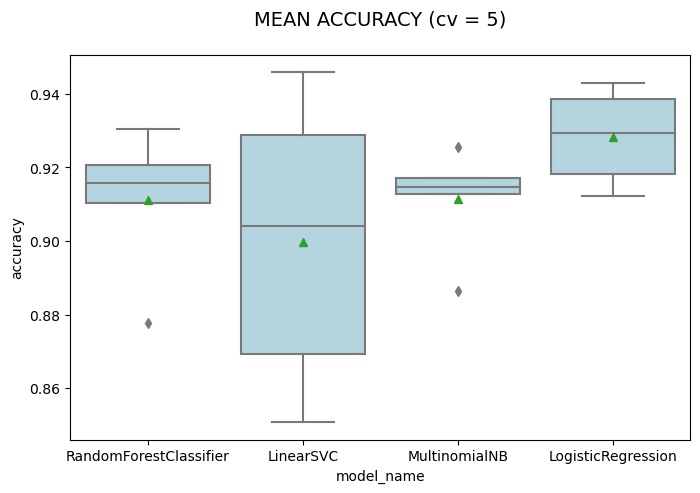

In [32]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

TF-IDF LOGREG APPROACH

In [40]:
filtered_df.shape

(8139, 48)

In [49]:
filtered_df['fe_categorycombined'] = filtered_df['fe_category0'] + '/' + filtered_df['fe_category1']

In [50]:
# put a limit on maximal number of features and minimal word frequency
tf_idf = TfidfVectorizer(max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = LogisticRegression(C=1e2, n_jobs=4, solver='lbfgs', 
                           random_state=0, verbose=0, 
                           multi_class='multinomial',
                           fit_intercept=True)
# sklearn's pipeline
base_model = Pipeline([('tf_idf', tf_idf), 
                       ('logit', logit)])

In [78]:
class TfIdfLogitPipelineHierarchical(BaseEstimator):
    
    def __init__(self, 
                 base_model, 
                 model_store_path,
                 class_separator = '/',
                 min_size_to_train=50
                ):
        """

        :param base_model: Sklearn model to train, one instance for level 1,
                           and several instances for level 2 
        :param model_store_path: where to store models as pickle files
        :param class_separator: separator between level 1 and level 2 class names
        :param min_size_to_train: do not train a model with less data
        """
        self.base_model = base_model
        self.model_store_path = Path(model_store_path)
        self.class_separator = class_separator
        self.min_size_to_train = min_size_to_train
        
        self.model_store_path.mkdir(exist_ok=True)
        
    def fit(self, X, y):
        
        lev1_classes = [label.split(self.class_separator)[0]
                        for label in y]
        
        with timer('Training level 1 model'):
            self.base_model.fit(X, lev1_classes)
            
            
            with open(self.model_store_path / 'level1_model.pkl', 'wb') as f:
                pickle.dump(self.base_model, f)
        
        
        for lev1_class in np.unique(lev1_classes):
            
            with timer(f'Training level 2 model for class: {lev1_class}'):
                curr_X = X.loc[y.str.startswith(lev1_class)]
                curr_y = y.loc[y.str.startswith(lev1_class)].apply(lambda s: s.split(self.class_separator)[1])
                
                if len(curr_X) < self.min_size_to_train:
                    print(f"Skipped class {lev1_class.replace(' ', '_')} due to a too small dataset size: {len(curr_X)}")
                    continue
                    
                self.base_model.fit(curr_X, curr_y)
                
                model_name = f"level2_model_{lev1_class.replace(' ', '_')}.pkl"
                
                with open(self.model_store_path / model_name, 'wb') as f:
                    pickle.dump(self.base_model, f)
    
    def predict(self, X):
        
        model_name =  'level1_model.pkl'
        with open(self.model_store_path / model_name, 'rb') as f:
            level1_model = pickle.load(f)
        
        level1_preds = level1_model.predict(X)
            
        level2_preds = np.zeros_like(level1_preds)
            
        for lev1_class in np.unique(level1_preds):
            
            idx = level1_preds == lev1_class
            curr_X = X.iloc[idx]
            
            model_name = f"level2_model_{lev1_class.replace(' ', '_')}.pkl"
            
            if Path(self.model_store_path / model_name).exists():
            
                with open(self.model_store_path / model_name, 'rb') as f:
                    level2_model = pickle.load(f)

                curr_level2_preds = level2_model.predict(curr_X)
                level2_preds[idx] = curr_level2_preds
            
            else:
                level2_preds[idx] = lev1_class
                
        return level1_preds, level2_preds  

In [108]:
description_model = TfIdfLogitPipelineHierarchical(
            base_model=base_model,
            model_store_path='models'
)

In [110]:
#Description test
X_train, X_test, y_train, y_test = train_test_split(filtered_df['description'], 
                                                    filtered_df['fe_categorycombined'], 
                                                    test_size=0.33, random_state=42)

In [111]:
description_model.fit(X_train, y_train)

/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Training level 1 model] done in 7 s
[Training level 2 model for class: Automotive] done in 1 s
[Training level 2 model for class: Baby & Toys] done in 0 s
Skipped class Cameras_&_Drones due to a too small dataset size: 2
[Training level 2 model for class: Cameras & Drones] done in 0 s
[Training level 2 model for class: Fashion Accessories] done in 0 s
Skipped class Games,_Books_&_Hobbies due to a too small dataset size: 34
[Training level 2 model for class: Games, Books & Hobbies] done in 0 s
Skipped class Groceries_&_Pets due to a too small dataset size: 7
[Training level 2 model for class: Groceries & Pets] done in 0 s
Skipped class Health_&_Beauty due to a too small dataset size: 25
[Training level 2 model for class: Health & Beauty] done in 0 s
Skipped class Home_&_Living due to a too small dataset size: 15
[Training level 2 model for class: Home & Living] done in 0 s
[Training level 2 model for class: Men Clothes] done in 0 s
Skipped class Men_Shoes due to a too small dataset siz

/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Training level 2 model for class: Sports & Outdoor] done in 4 s
Skipped class Travel_&_Luggage due to a too small dataset size: 2
[Training level 2 model for class: Travel & Luggage] done in 0 s
Skipped class Women_Clothes due to a too small dataset size: 3
[Training level 2 model for class: Women Clothes] done in 0 s
Skipped class Women's_Bags due to a too small dataset size: 1
[Training level 2 model for class: Women's Bags] done in 0 s


In [112]:
level1_pred, level2_pred = model.predict(X_test)

In [113]:
y_test_eval = y_test.apply(lambda x : x.split('/'))
y_test_eval = pd.DataFrame(y_test_eval.values.tolist()).add_prefix('cat')

In [114]:
f1_score(y_true=y_test_eval['cat0'], y_pred=level1_pred, average='micro').round(3),\
f1_score(y_true=y_test_eval['cat0'], y_pred=level1_pred, average='weighted').round(3)

(0.948, 0.942)

In [115]:
f1_score(y_true=y_test_eval['cat1'], y_pred=level2_pred, average='micro').round(3),\
f1_score(y_true=y_test_eval['cat1'], y_pred=level2_pred, average='weighted').round(3)

(0.888, 0.872)

In [116]:
print(classification_report(
    y_true=y_test_eval['cat0'], 
    y_pred=level1_pred)
)

                        precision    recall  f1-score   support

            Automotive       0.73      0.41      0.52        66
           Baby & Toys       0.77      0.54      0.63        37
   Fashion Accessories       0.63      0.65      0.64        34
Games, Books & Hobbies       0.92      0.86      0.89        14
      Groceries & Pets       0.00      0.00      0.00         1
       Health & Beauty       0.88      0.50      0.64        14
         Home & Living       0.00      0.00      0.00         3
           Men Clothes       0.72      0.54      0.62        39
             Men Shoes       0.00      0.00      0.00         0
  Men's Bags & Wallets       0.00      0.00      0.00         2
  Mobile & Accessories       0.00      0.00      0.00         4
      Sports & Outdoor       0.96      0.99      0.97      2472

              accuracy                           0.95      2686
             macro avg       0.47      0.37      0.41      2686
          weighted avg       0.94     

/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tooshy/anaconda3/lib/python3.9/si

In [117]:
print(classification_report(
    y_true=y_test_eval['cat1'], 
    y_pred=level2_pred)
)

                                 precision    recall  f1-score   support

Automotive Merchandise & Others       0.00      0.00      0.00         2
                      Baby Gear       0.00      0.00      0.00         3
                Car Accessories       0.00      0.00      0.00         1
              Car Oils & Fluids       0.00      0.00      0.00         1
          Car Replacement Parts       0.67      0.29      0.40         7
                 Cases & Covers       0.00      0.00      0.00         2
                        Cereals       0.00      0.00      0.00         1
                   Cool Gadgets       0.00      0.00      0.00         1
                 Crossbody Bags       0.00      0.00      0.00         1
               Cycling & Skates       0.93      0.98      0.95      2287
         Exercise & Fitness Equ       0.00      0.00      0.00         0
   Exercise & Fitness Equipment       0.00      0.00      0.00        12
                        Eyewear       0.75      0.

/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tooshy/anaconda3/lib/python3.9/si

In [121]:
productname_model = TfIdfLogitPipelineHierarchical(
            base_model=base_model,
            model_store_path='models'
)

In [122]:
#Description test
X_train, X_test, y_train, y_test = train_test_split(filtered_df['product_name'], 
                                                    filtered_df['fe_categorycombined'], 
                                                    test_size=0.33, random_state=42)

In [123]:
productname_model.fit(X_train, y_train)

/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Training level 1 model] done in 2 s
[Training level 2 model for class: Automotive] done in 0 s
[Training level 2 model for class: Baby & Toys] done in 0 s
Skipped class Cameras_&_Drones due to a too small dataset size: 2
[Training level 2 model for class: Cameras & Drones] done in 0 s
[Training level 2 model for class: Fashion Accessories] done in 0 s
Skipped class Games,_Books_&_Hobbies due to a too small dataset size: 34
[Training level 2 model for class: Games, Books & Hobbies] done in 0 s
Skipped class Groceries_&_Pets due to a too small dataset size: 7
[Training level 2 model for class: Groceries & Pets] done in 0 s
Skipped class Health_&_Beauty due to a too small dataset size: 25
[Training level 2 model for class: Health & Beauty] done in 0 s
Skipped class Home_&_Living due to a too small dataset size: 15
[Training level 2 model for class: Home & Living] done in 0 s
[Training level 2 model for class: Men Clothes] done in 0 s
Skipped class Men_Shoes due to a too small dataset siz

/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [124]:
level1_pred, level2_pred = productname_model.predict(X_test)

In [125]:
y_test_eval = y_test.apply(lambda x : x.split('/'))
y_test_eval = pd.DataFrame(y_test_eval.values.tolist()).add_prefix('cat')

In [126]:
f1_score(y_true=y_test_eval['cat0'], y_pred=level1_pred, average='micro').round(3),\
f1_score(y_true=y_test_eval['cat0'], y_pred=level1_pred, average='weighted').round(3)

(0.952, 0.949)

In [127]:
f1_score(y_true=y_test_eval['cat1'], y_pred=level2_pred, average='micro').round(3),\
f1_score(y_true=y_test_eval['cat1'], y_pred=level2_pred, average='weighted').round(3)

(0.888, 0.878)

In [128]:
print(classification_report(
    y_true=y_test_eval['cat0'], 
    y_pred=level1_pred)
)

                        precision    recall  f1-score   support

            Automotive       0.65      0.50      0.56        66
           Baby & Toys       0.69      0.68      0.68        37
   Fashion Accessories       0.69      0.65      0.67        34
Games, Books & Hobbies       0.93      1.00      0.97        14
      Groceries & Pets       0.00      0.00      0.00         1
       Health & Beauty       0.90      0.64      0.75        14
         Home & Living       0.00      0.00      0.00         3
           Men Clothes       0.74      0.64      0.68        39
  Men's Bags & Wallets       0.00      0.00      0.00         2
  Mobile & Accessories       1.00      0.25      0.40         4
      Sports & Outdoor       0.97      0.98      0.98      2472

              accuracy                           0.95      2686
             macro avg       0.60      0.49      0.52      2686
          weighted avg       0.95      0.95      0.95      2686



/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [129]:
print(classification_report(
    y_true=y_test_eval['cat1'], 
    y_pred=level2_pred)
)

/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tooshy/anaconda3/lib/python3.9/si

                                 precision    recall  f1-score   support

Automotive Merchandise & Others       0.00      0.00      0.00         2
                      Baby Gear       0.00      0.00      0.00         3
                Car Accessories       0.00      0.00      0.00         1
              Car Oils & Fluids       0.33      1.00      0.50         1
          Car Replacement Parts       0.00      0.00      0.00         7
                 Cases & Covers       0.00      0.00      0.00         2
                        Cereals       0.00      0.00      0.00         1
                   Cool Gadgets       0.00      0.00      0.00         1
                 Crossbody Bags       0.00      0.00      0.00         1
               Cycling & Skates       0.95      0.97      0.96      2287
         Exercise & Fitness Equ       0.00      0.00      0.00         0
   Exercise & Fitness Equipment       0.00      0.00      0.00        12
                        Eyewear       0.86      0.

/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tooshy/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
